In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import keras
import PIL

import keras.backend as K
from tensorflow.python.framework import ops

from scipy import ndimage
import copy

from collections import OrderedDict

Using TensorFlow backend.


In [2]:
##
# Load model and set up model
##

# Can be downloaded here: https://drive.google.com/file/d/1gq7QFVzBxzw-jGiKB1siJzvxg5mGuUH6/view
# Original CNTK model was trained by kanotype: http://twitter.com/kanotype
classif_model = keras.models.load_model("kanotype_deepdanbooru_resnet-custom-v2.hdf5")
#classif_model.summary()

# Load tags
with open("kanotype_deepdanbooru_resnet-custom-v2_tags.txt", 'r') as tags_stream:
    all_tags = np.array([tag for tag in (tag.strip() for tag in tags_stream) if tag])

# For grad-cam: Create gradient class selector input
class_selector_shape = (tf.Dimension(None), len(all_tags), 1)
class_selector_input = tf.placeholder(tf.float32, name = "gradcam_class_selector", shape = class_selector_shape)    

# Create loss and output for grad-cam
out_layer = classif_model.layers[-1].output
gradcam_loss_func = tf.multiply(out_layer, class_selector_input)
gradcam_loss = tf.reduce_sum(gradcam_loss_func)
grads_vars = tf.gradients(gradcam_loss, [classif_model.layers[0].input])

# Tensorflow session from keras
sess = K.get_session()

C:\Python\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
##
# Functions for input / preprocessing
##
def read_image(in_path):
    """
    Loads an image and returns it two different ways: Preprocessed for DeepDanbooru, 
    and untouched
    """

    image_fullres = PIL.Image.open(in_path).convert('RGB')
    image_processed = np.array(copy.deepcopy(image_fullres).resize((299, 299), resample = PIL.Image.LANCZOS)) / 255.0
    
    return image_fullres, image_processed

In [4]:
##
# Functions for tag estimation
##
def decode_tags(image_arrays, threshold = 0.1):
    """
    Decode tags using DeepDanbooru, threshold them and return them
    as a sorted dict (highest likelihood first)
    
    Will return a list if a list is passed.
    """
    if len(np.array(image_arrays).shape) == 4:
        return_list = True
    else:
        image_arrays = np.array([image_arrays])
        return_list = False
    
    # Decode
    results = classif_model.predict(image_arrays).reshape(-1, all_tags.shape[0])

    # Threshold and sort
    result_list = []
    for result_set in results:
        result_tags = {}
        for i in range(len(all_tags)):
            if result_set[i] > threshold:
                result_tags[all_tags[i]] = result_set[i]
  
        sorted_tags = reversed(sorted(result_tags.keys(), key = lambda x: result_tags[x]))
        sorted_results = OrderedDict()
        for tag in sorted_tags:
            sorted_results[tag] = result_tags[tag]
        result_list.append(sorted_results)
    
    if return_list:
        return result_list
    else:
        return result_list[0]
    
def show_tags(result_tags):
    """
    Tag list prettyprinter
    """
    for tag in result_tags.keys():
        print('    {0: <32} {1:04f}'.format(tag, result_tags[tag]))
    

In [5]:
##
# Actual gradcam code
##
def gradcam(image_array, class_sets, batch_size = 5, verbose = False):
    """
    Get gradient at inputs that maximizes the given class(es)
    
    Operates on batches to go faster
    """
    image_feed = np.array([image_array] * batch_size)
    results = []
    for batch_start in range(0, len(class_sets), batch_size):
        if verbose:
            print("Batch: {} to {} of {}".format(batch_start, batch_start+batch_size, len(class_sets)))
        batch = class_sets[batch_start:batch_start + batch_size]
        
        batch_nhot_list = []
        for classes in batch:
            if not isinstance(classes, list):
                classes = [classes]

            class_nhot = np.zeros(len(all_tags))
            for gradcam_class in classes:
                class_idx = list(all_tags).index(gradcam_class)
                class_nhot[class_idx] = 1.0
            class_nhot = class_nhot.reshape(class_nhot.shape[0], 1)
            batch_nhot_list.append(class_nhot)

        results.extend(list(sess.run(grads_vars[0], feed_dict = {
            classif_model.layers[0].input: image_feed[0:len(batch_nhot_list), :, :, :],
            class_selector_input: np.array(batch_nhot_list)
        })))
        
    return np.array(results)

In [6]:
##
# Functions for activation map processing
##
def norm_clip_grads(grads):
    """
    Normalize gradcam gradients by clipping them to between the 1st and 
    the 99th percentile, taking the absolute value and then mapping that 
    range to 0 -> 1
    """
    upper_quantile = np.quantile(grads, 0.99)
    lower_quantile = np.quantile(grads, 0.01)
    clipped_grads = np.abs(np.clip(grads, lower_quantile, upper_quantile))
    return clipped_grads / np.max(clipped_grads)

def postprocess_grads(grads, filter_width = 10):
    """
    Normalize gradients, take the mean and apply
    a median filter
    """
    gradcam_map = np.mean(norm_clip_grads(grads), axis = -1)
    return ndimage.median_filter(gradcam_map, filter_width)
 
def threshold_map(gradcam_map, all_maps, filter_width = 10):
    """
    Refine gradcam map by applying a threshold mask that zeroes out
    areas where the map is not bigger than the average of all maps
    (i.e. remove areas that are only "generally interesting" instead
    of interesting for this tag specifically)
    """
    threshold_mask = gradcam_map > np.mean(all_maps, axis = 0)
    return ndimage.median_filter(threshold_mask, filter_width) * gradcam_map

def mask_for_tags(tags, gradcam_maps_processed, clip_value = 0.3, regu_value = 0.0, median_filter_width = 10, anti_tags = None):
    """
    Given tag(s) and a set of (normalized) gradcam maps, generate a mask of pixels
    that contribute to the image being assigned those tags
    
    Maps are combined multiplicatively, anti-tags (if specified) are used inversely
    """
    if not isinstance(tags, list):
        tags = [tags]
    
    tags_map = np.ones(gradcam_maps_processed[tags[0]].shape)
    for tag in tags:
        tag_map = threshold_map(gradcam_maps_processed[tag], list(gradcam_maps_processed.values()))
        tag_map = ndimage.median_filter(tag_map, median_filter_width)
        tag_map /= np.max(tag_map)
        tags_map *= tag_map
    
    if not anti_tags is None:
        for tag in anti_tags:
            if tag in gradcam_maps_processed:
                tag_map = threshold_map(gradcam_maps_processed[tag], list(gradcam_maps_processed.values()))
                tag_map = ndimage.median_filter(tag_map, median_filter_width)
                tag_map /= np.max(tag_map)
                tags_map *= (1.0 - tag_map)
            
    tags_map /= np.max(tags_map)
    tags_map = np.maximum(tags_map, clip_value)
    tags_map += regu_value
    tags_map /= np.max(tags_map)
    
    return tags_map

def show_mask(image, mask):
    """
    Show a nice plot of an image, a mask, and the masked image
    """
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.xlabel("Input image")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, vmin = 0.0, vmax = 1.0)
    plt.xlabel("Activation mask")

    plt.subplot(1, 3, 3)
    plt.imshow(image * np.repeat(mask, 3).reshape(image.shape))
    plt.xlabel("Masked image")
    
def plot_tags(image_arr, gradcam_maps_processed, tags, anti_tags = None):
    """
    Get mask for tag and plot
    """
    mask = mask_for_tags(tags, gradcam_maps_processed, 0.2, anti_tags = anti_tags)
    show_mask(image_arr, mask)
    title = "Mask for tags: '{}'".format(" ".join(tags))
    if not anti_tags is None:
        title += " excluding '{}'".format(" ".join(anti_tags))
    plt.suptitle(title)

In [7]:
##
# Postprocessing and masking code
##
def mask_image(image_fullres, gradcam_maps_processed, tags_to_mask, tags_to_keep, inverse = False, pixelate = True, dilation_scale = 1.0):
    """
    Find a tag mask and apply it to a full-resolution image (either blacking 
    out or pixelating regions)
    """
    # Get a combined (additive) mask for these tags
    mask = np.zeros(gradcam_maps_processed[list(gradcam_maps_processed.keys())[0]].shape)
    for tag_set, mask_thresh in tags_to_mask:
        if not isinstance(tag_set, list):
            tag_set = [tag_set]

        tag_set_real = []
        for tag in tag_set:
            if tag in gradcam_maps_processed:
                tag_set_real.append(tag)
        if len(tag_set_real) > 0:
            # The threshold can be adjusted to make the mask more or less inclusive, but 0.2 seems
            # to work generally okay
            temp_mask = mask_for_tags(tag_set_real, gradcam_maps_processed, 0.0, anti_tags = tags_to_keep) < mask_thresh
            mask += 1.0 - temp_mask
    mask = 1.0 - np.clip(mask, 0.0, 1.0)
    if inverse:
        mask = 1.0 - mask
        
    # Do some hole / noise removal and make the mask a tad larger
    mask = ndimage.morphology.binary_dilation(mask, iterations=int(5 * dilation_scale), border_value = 1)
    mask = ndimage.morphology.binary_erosion(mask, iterations=int(10 * dilation_scale), border_value = 1) * 1.0

    # Load full res image and make mask the same size
    mask_image = np.repeat(mask.reshape(mask.shape[0], mask.shape[1], 1), 3, axis = -1) * 255.0
    mask_image = PIL.Image.fromarray(mask_image.astype("uint8"))

    mask_image = mask_image.resize(image_fullres.size, resample = PIL.Image.LANCZOS)

    # Gauss filter to make everything look nice and soft
    mask = np.array(mask_image)[:, :, 0] / 255.0
    mask = ndimage.gaussian_filter(mask, 3)

    # Create a pixelated version of the image
    image_fullres_arr = np.array(image_fullres)
    image_fullres_pixeled = image_fullres.resize(np.array(image_fullres.size) // 15).resize(image_fullres.size)
    pixeled_arr = np.array(image_fullres_pixeled)

    # Combined input and pixelated using mask
    masked_image = np.array(image_fullres_arr * np.repeat(mask, 3).reshape(image_fullres_arr.shape))
    if pixelate == True:
        pixeled_image = np.array(pixeled_arr * np.repeat(1.0 - mask, 3).reshape(image_fullres_arr.shape))
        final_image = masked_image + pixeled_image
    else:
        final_image = masked_image
        
    # Return masked image, as a PIL image
    return PIL.Image.fromarray(final_image.astype("uint8"))

Loading image: hibiki.jpg

Estimating tags:
    ganaha_hibiki                    0.998756
    1girl                            0.995790
    jewelry                          0.993498
    animal                           0.984292
    rating:safe                      0.983508
    ponytail                         0.959574
    breasts                          0.956939
    long_hair                        0.956815
    earrings                         0.941768
    black_hair                       0.919423
    open_mouth                       0.901638
    score:very_good                  0.897160
    hamster                          0.878725
    blue_eyes                        0.854218
    fang                             0.848022
    barefoot                         0.833460
    swimsuit                         0.829083
    smile                            0.815426
    cleavage                         0.786772
    dog                              0.782905
    bikini                          

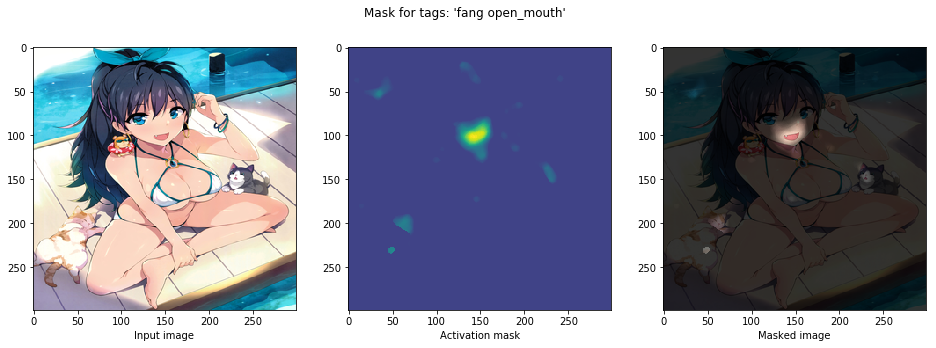

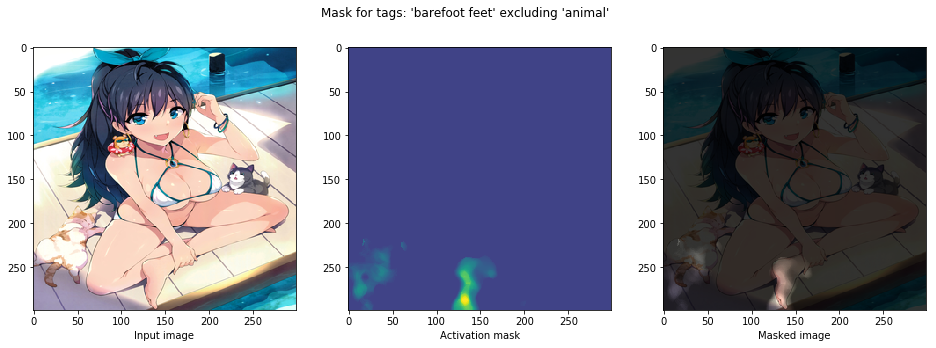

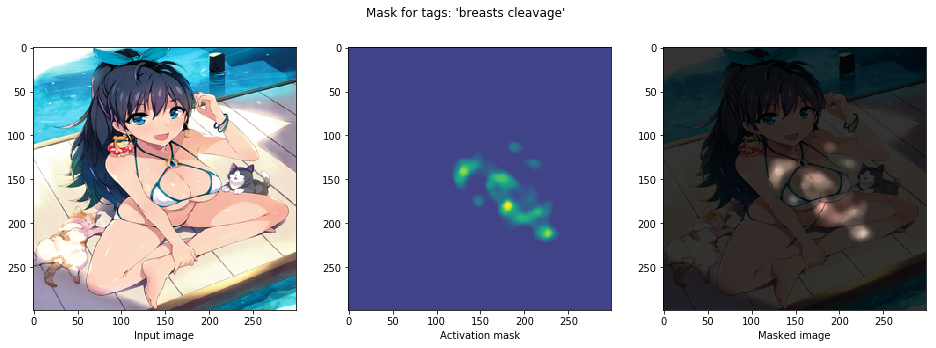

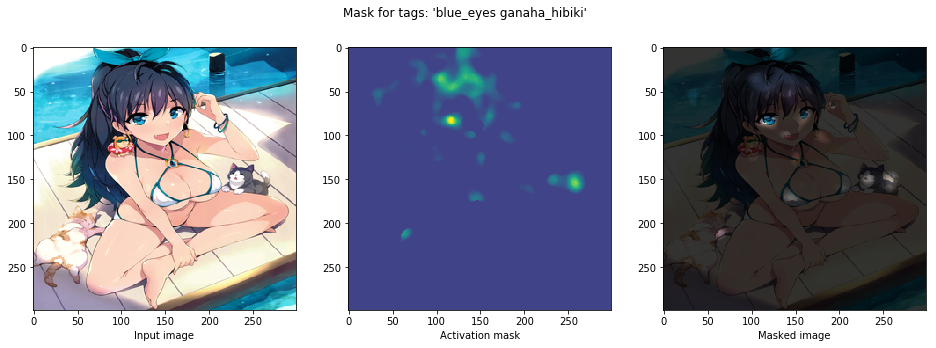

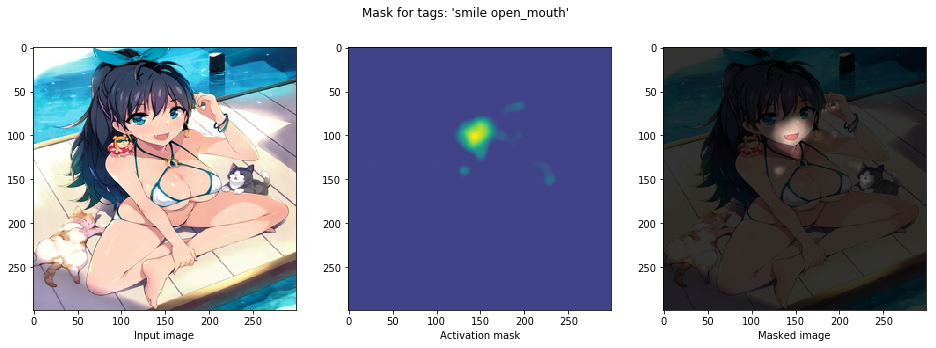

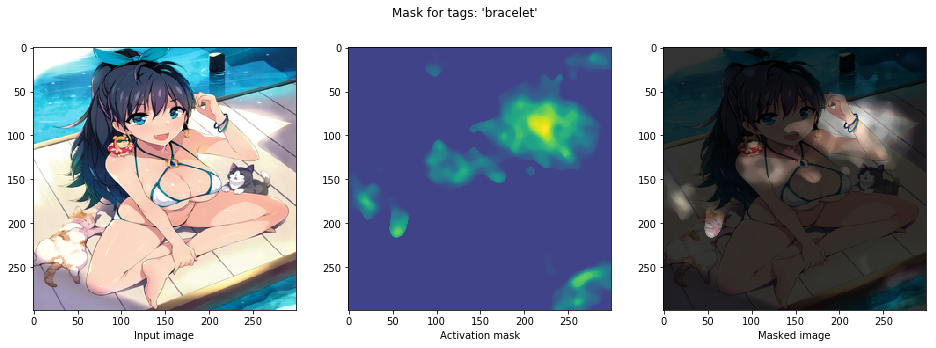

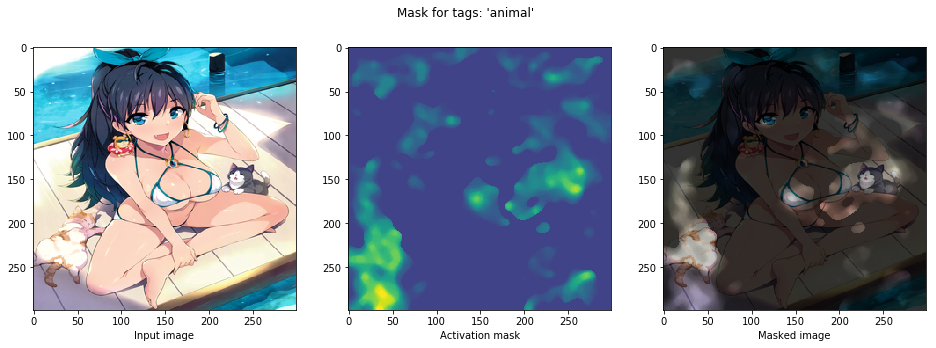

In [8]:
##
# Actual code that really does things below
##

# It's everyone's favourite idol, Hibiki Ganaha: https://gelbooru.com/index.php?page=post&s=view&id=4767465
in_file = "hibiki.jpg"

# Load an image
print("Loading image:", in_file)
image_fullres, image_array = read_image(in_file)

# Estimate tags
print("\nEstimating tags:")
tags = decode_tags(image_array)
show_tags(tags)

# Run gradcam
print("\nFinding gradients")
result_tag_list = list(tags.keys())
gradcam_maps = dict(zip(result_tag_list, gradcam(image_array, result_tag_list, batch_size = 5, verbose = True)))

# Process gradients
print("\nFinding activation maps")
gradcam_maps_processed = dict(zip(gradcam_maps.keys(), list(map(postprocess_grads, gradcam_maps.values()))))

# Show some examples
plot_tags(image_array, gradcam_maps_processed, ["fang", "open_mouth"])
plot_tags(image_array, gradcam_maps_processed, ["barefoot", "feet"], ["animal"])
plot_tags(image_array, gradcam_maps_processed, ["breasts", "cleavage"])
plot_tags(image_array, gradcam_maps_processed, ["blue_eyes", "ganaha_hibiki"])
plot_tags(image_array, gradcam_maps_processed, ["smile", "open_mouth"])
plot_tags(image_array, gradcam_maps_processed, ["bracelet"])
plot_tags(image_array, gradcam_maps_processed, ["animal"])

# Load an image
print("Loading image:", in_file)
image_fullres, image_array = read_image(in_file)

# Estimate tags
print("\nEstimating tags:")
tags = decode_tags(image_array)
show_tags(tags)

# Run gradcam
print("\nFinding gradients")
result_tag_list = list(tags.keys())
gradcam_maps = dict(zip(result_tag_list, gradcam(image_array, result_tag_list, batch_size = 5, verbose = True)))

# Process gradients
print("\nFinding activation maps")
gradcam_maps_processed = dict(zip(gradcam_maps.keys(), list(map(postprocess_grads, gradcam_maps.values()))))

# Show some examples
plot_tags(image_array, gradcam_maps_processed, ["fang", "open_mouth"])
plot_tags(image_array, gradcam_maps_processed, ["barefoot", "feet"], ["animal"])
plot_tags(image_array, gradcam_maps_processed, ["breasts", "cleavage"])
plot_tags(image_array, gradcam_maps_processed, ["blue_eyes", "ganaha_hibiki"])
plot_tags(image_array, gradcam_maps_processed, ["smile", "open_mouth"])
plot_tags(image_array, gradcam_maps_processed, ["bracelet"])
plot_tags(image_array, gradcam_maps_processed, ["animal"])